In [2]:
from modules.smpl_model._smpl import SMPL as SMPL_metro
from modules.utils.image_utils import plot_tensor, to_tensor, visualize_mesh
from modules.smpl_model.config_smpl import *
from modules.smpl_model.smpl_pose2mesh import SMPL

from modules.datasets.dataset_3DPW import get_data as get_data_3dpw
from modules.datasets.dataset_H36M import get_data as get_data_h36m
from modules.datasets.FullDataset import get_full_train_val_data
from modules.smpl_model.smpl_pose2mesh import SMPL

In [3]:
import torch
import os.path as osp
import json
import copy
import numpy as np
import os
import pickle as pkl
from PIL import Image
import torch
import random

## SMPL Model Pose2Mesh

In [4]:
smpl = SMPL()
smpl_metro = SMPL_metro()

# Adapt Regressor for 10 PCs
smpl.layer['neutral'].th_shapedirs= smpl.layer['neutral'].th_shapedirs[:,:,:10]
smpl.layer['neutral'].th_betas= smpl.layer['neutral'].th_betas[:,:10]

/Users/clara/Desktop/MeineProjekte/HMR_3DWP/modules/smpl_model/smplpytorch/smplpytorch/pytorch/smpl_layer.py:40: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459065530/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


## Dataset H36M

In [5]:
datah36m = get_data_h36m(data_path='../H36M',
                        subject_list = [11],
                        img_size=224,
                        load_datalist='../H36M/data_pickle/datalist_h36m_thr25_11to11subj.pickle', 
                        load_from_zarr=['../H36M/img_zarr/imgs_h36m_resnet_thr25_11to11subj.zarr'],
                        mask=True,
                        smpl=smpl.layer['neutral'],
                        backgrounds = None,
                        store_images=False)

[11]
11 ../H36M/img_zarr/imgs_h36m_resnet_thr25_11to11subj.zarr ['.DS_Store', 'imgs_h36m_resnet_thr25_11to11subj.zarr']


In [35]:
img = dat['img']
img_path= dat['img_path']
verts = dat['vertices']
cam_pose =dat['cam_pose']
cam_intr = dat['cam_intr']
trans = dat['trans']

In [40]:
orig_img = np.array(Image.open(img_path))
orig_img = to_tensor(orig_img)

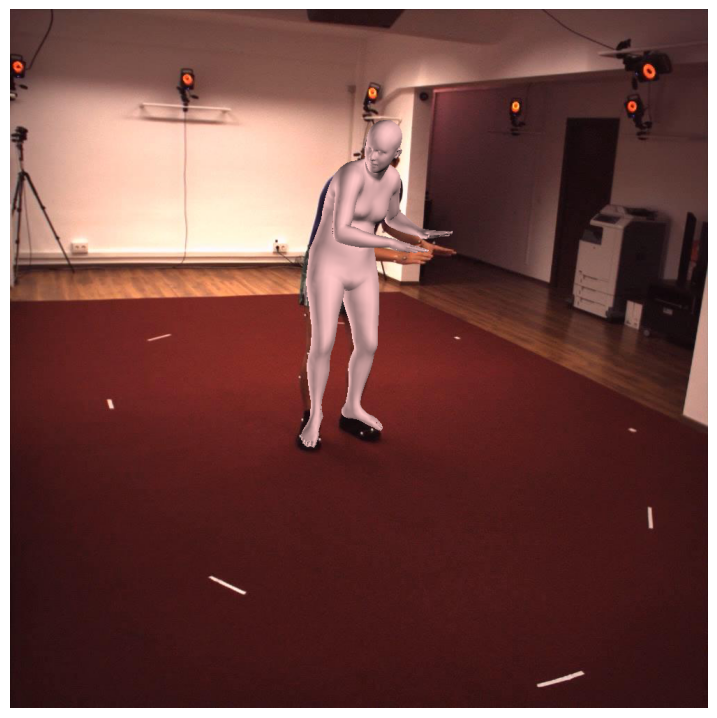

In [42]:
rend_img = visualize_mesh(orig_img, smpl=smpl_metro, cam_intr=cam_intr, vertices=(verts+trans)[None])
plot_tensor(rend_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


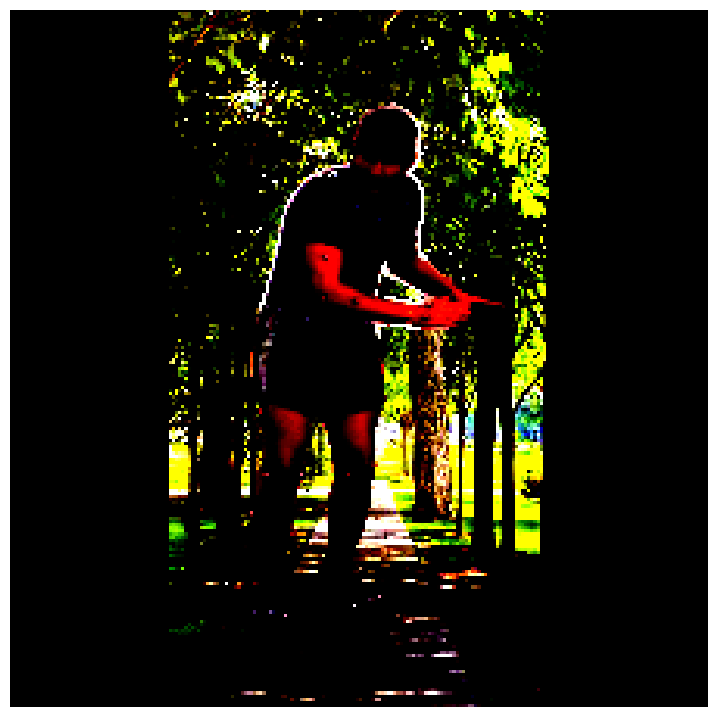

In [43]:
plot_tensor(img)

## Full Dataset

In [1]:
from modules.datasets.FullDataset import get_full_train_val_data

In [27]:
train_data_3dpw = get_data_3dpw(data_path='../3DPW', 
                                    split='train',
                                    num_required_keypoints=8,
                                    store_sequences=True,
                                    store_images=True,
                                    load_from_zarr=None,
                                    img_size=224,
                                    load_ids_imgpaths_seq='data/ids_imgpaths_seq/ids_paths_seq_train_min8_kps.pickle',
                                    smpl=smpl.layer['neutral'],)

In [13]:
train_data, val_data = get_full_train_val_data(
        data_path_3dpw='../3DPW',
        num_required_keypoints = 8,
        store_sequences=True,
        store_images=True,
        load_from_zarr_3dpw_trn=None,
        load_from_zarr_3dpw_val=None,
        img_size=224,
        load_ids_imgpaths_seq_trn='data/ids_imgpaths_seq/ids_paths_seq_train_min8_kps.pickle',
        load_ids_imgpaths_seq_val='data/ids_imgpaths_seq/ids_paths_seq_validation_min8_kps.pickle',
        data_path_h36m='../H36M',
        load_from_zarr_h36m_trn=None,
        load_datalist_trn=data_pickle,
        backgrounds=backgrounds,
        mask=True,
    )

In [14]:
len(train_data), len(val_data)

(23194, 10402)

## Render Mesh

In [11]:
from modules.utils.image_utils import visualize_mesh

## Render Image for each camera

In [12]:
cam1 = copy.deepcopy(datalist[0])

cam_pose = cam1['cam_pose']
cam_intr = cam1['cam_intr']
beta = cam1['betas']
pose= cam1['poses']
trans = cam1['trans']
verts_cam, _= get_smpl_coord(pose=pose, beta=beta, trans=trans, root_idx=0, cam_pose=cam_pose, smpl=smpl.layer['neutral'])
#verts_cam += trans
img_path = osp.join('../H36M/images/', cam1['img_name'])

In [13]:
verts_cam.shape

torch.Size([1, 6890, 3])

In [110]:
cam2 = copy.deepcopy(datalist[300])

cam_pose = cam2['cam_pose']
cam_intr = cam2['cam_intr']
beta = cam2['betas']
pose= cam2['poses']
trans = cam2['trans']
verts_cam, _= get_smpl_coord(pose=pose, beta=beta,trans=trans, root_idx=0, cam_pose=cam_pose, smpl=smpl.layer['neutral'])
#verts_cam += trans
img_path = osp.join('../H36M/images/', cam2['img_name'])

In [112]:
cam3 = copy.deepcopy(datalist[100])

cam_pose = cam3['cam_pose']
cam_intr = cam3['cam_intr']
beta = cam3['betas']
pose= cam3['poses']
trans = cam3['trans']
verts_cam, _= get_smpl_coord(pose=pose, beta=beta,trans=trans, root_idx=0, cam_pose=cam_pose, smpl=smpl.layer['neutral'])
#verts_cam += trans
img_path = osp.join('../H36M/images/', cam3['img_name'])

In [120]:
cam4 = copy.deepcopy(datalist[400])
cam_pose = cam4['cam_pose']
cam_intr = cam4['cam_intr']
beta = cam4['betas']
pose= cam4['poses']
trans = cam4['trans']
verts_cam, _= get_smpl_coord(pose=pose, beta=beta,trans=trans, root_idx=0, cam_pose=cam_pose, smpl=smpl.layer['neutral'])
#verts_cam += trans
img_path = osp.join('../H36M/images/', cam4['img_name'])

In [14]:
orig_img = to_tensor(Image.open(img_path))
rend_img = visualize_mesh(orig_img, smpl=smpl_metro, cam_intr=cam_intr, vertices=verts_cam)
plot_tensor(rend_img)

FileNotFoundError: [Errno 2] No such file or directory: '../H36M/images/s_01_act_02_subact_01_ca_01/s_01_act_02_subact_01_ca_01_000001.jpg'

### Chunks 

In [26]:
from modules.utils.data_utils_3dpw import rand_partition
from modules.utils.data_utils_h36m import get_data_list_h36m
import collections

In [27]:
def get_data_chunk_list_h36m(annot_dir:str,
                    img_dir:str,
                    subject_list:list,
                    fitting_thr:int,
                    len_chunks=8,
                    load_seq_datalist:str=None,
                    load_datalist:str=None,
                    store_as_pkl:bool=False,
                    out_dir:str=None,
                    ):
        if load_seq_datalist is not None:
            with open(load_seq_datalist , "rb") as fp:
                seq_datalist = pkl.load(fp)
        else:
            datalist = get_data_list_h36m(load_from_pkl=load_datalist,
                                            annot_dir=annot_dir,
                                            subject_list=subject_list,
                                            fitting_thr=fitting_thr,
                                            store_as_pkl=False,
                                            )
            seq_name_to_data = collections.defaultdict(list)
            for data in datalist:
                img_name = data['img_name']
                seq_name = img_name.split('/')[0]
                seq_name_to_data[seq_name].append(data)
            seq_datalist = list(seq_name_to_data.values())
            if store_as_pkl:
                sub_str = f'{min(subject_list)}to{max(subject_list)}'
                with open(osp.join(out_dir, f'seq_datalist_h36m_thr{fitting_thr}_{sub_str}subj.pickle'), 'wb') as fp:
                    pkl.dump(seq_datalist, fp)
        chunks = [chunk for seq in seq_datalist for chunk in rand_partition(seq, len(seq)//len_chunks, len_chunks)]
        return chunks, seq_datalist
    

In [29]:
out_dir = '../H36M/data_pickle/'

In [32]:
chunks,seq_datalist= get_data_chunk_list_h36m(annot_dir,
                    img_dir,
                    subject_list=[7],
                    fitting_thr=25,
                    len_chunks=8,
                    load_seq_datalist=None,
                    load_datalist='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/datalist_h36m_thr25_7to7subj.pickle',
                    store_as_pkl=True,
                    out_dir=out_dir,
                    )

In [33]:
chunks,seq_datalist= get_data_chunk_list_h36m(annot_dir,
                    img_dir,
                    subject_list=[8],
                    fitting_thr=25,
                    len_chunks=8,
                    load_seq_datalist=None,
                    load_datalist='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/datalist_h36m_thr25_8to8subj.pickle',
                    store_as_pkl=True,
                    out_dir=out_dir,
                    )

In [88]:
chunks,seq_datalist= get_data_chunk_list_h36m(annot_dir,
                    img_dir,
                    subject_list=[1, 5, 6, 7, 8],
                    fitting_thr=25,
                    len_chunks=8,
                    load_seq_datalist=None,
                    load_datalist='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/datalist_h36m_thr25_1to8subj.pickle',
                    store_as_pkl=True,
                    out_dir=out_dir,
                    )

In [89]:
chunks,seq_datalist= get_data_chunk_list_h36m(annot_dir,
                    img_dir,
                    subject_list=[9, 11],
                    fitting_thr=25,
                    len_chunks=8,
                    load_seq_datalist=None,
                    load_datalist='/Users/clara/Desktop/MeineProjekte/H36M/data_pickle/datalist_h36m_thr25_9to11subj.pickle',
                    store_as_pkl=True,
                    out_dir=out_dir,
                    )

In [85]:
sum([len(seq) for seq in seq_datalist])

49296

In [84]:
len(chunks)

6100